In [1]:
!pip install plotly


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-2, 2, 400)
Y = np.where(X < 1, 1 + X - 2 * (X - 1)**2, 1 + X)

plt.figure(figsize=(8, 5))
plt.plot(X, Y, label=r'$\hat{Y}$')
plt.axvline(1, color='gray', linestyle='--', label='Transition at X=1')
plt.scatter([0, 1, 2], [1 + 0 - 2 * (0 - 1)**2, 1 + 1, 1 + 2], color='red', zorder=5)
plt.text(0, -1.5, 'Intercept at X=0', ha='center')
plt.text(1, 2.2, 'Transition', ha='center')
plt.xlabel('X')
plt.ylabel('Estimated Y')
plt.title('Estimated Curve for Piecewise Basis Functions')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from patsy import dmatrix

%matplotlib inline

In [5]:
df = pd.read_csv('./Auto.csv')

In [6]:
df['horsepower'].unique()  # Check if it's ok
# Replace '?' value by zero
df['horsepower'] = df['horsepower'].replace(to_replace = '?', value = '0')
df['horsepower'].unique()  # Check if it's ok

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '0', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [7]:
# Convert 'horsepower' to int
df['horsepower'] = df['horsepower'].astype(int)
type(df['horsepower'][0])  # Check if it's ok

numpy.int64

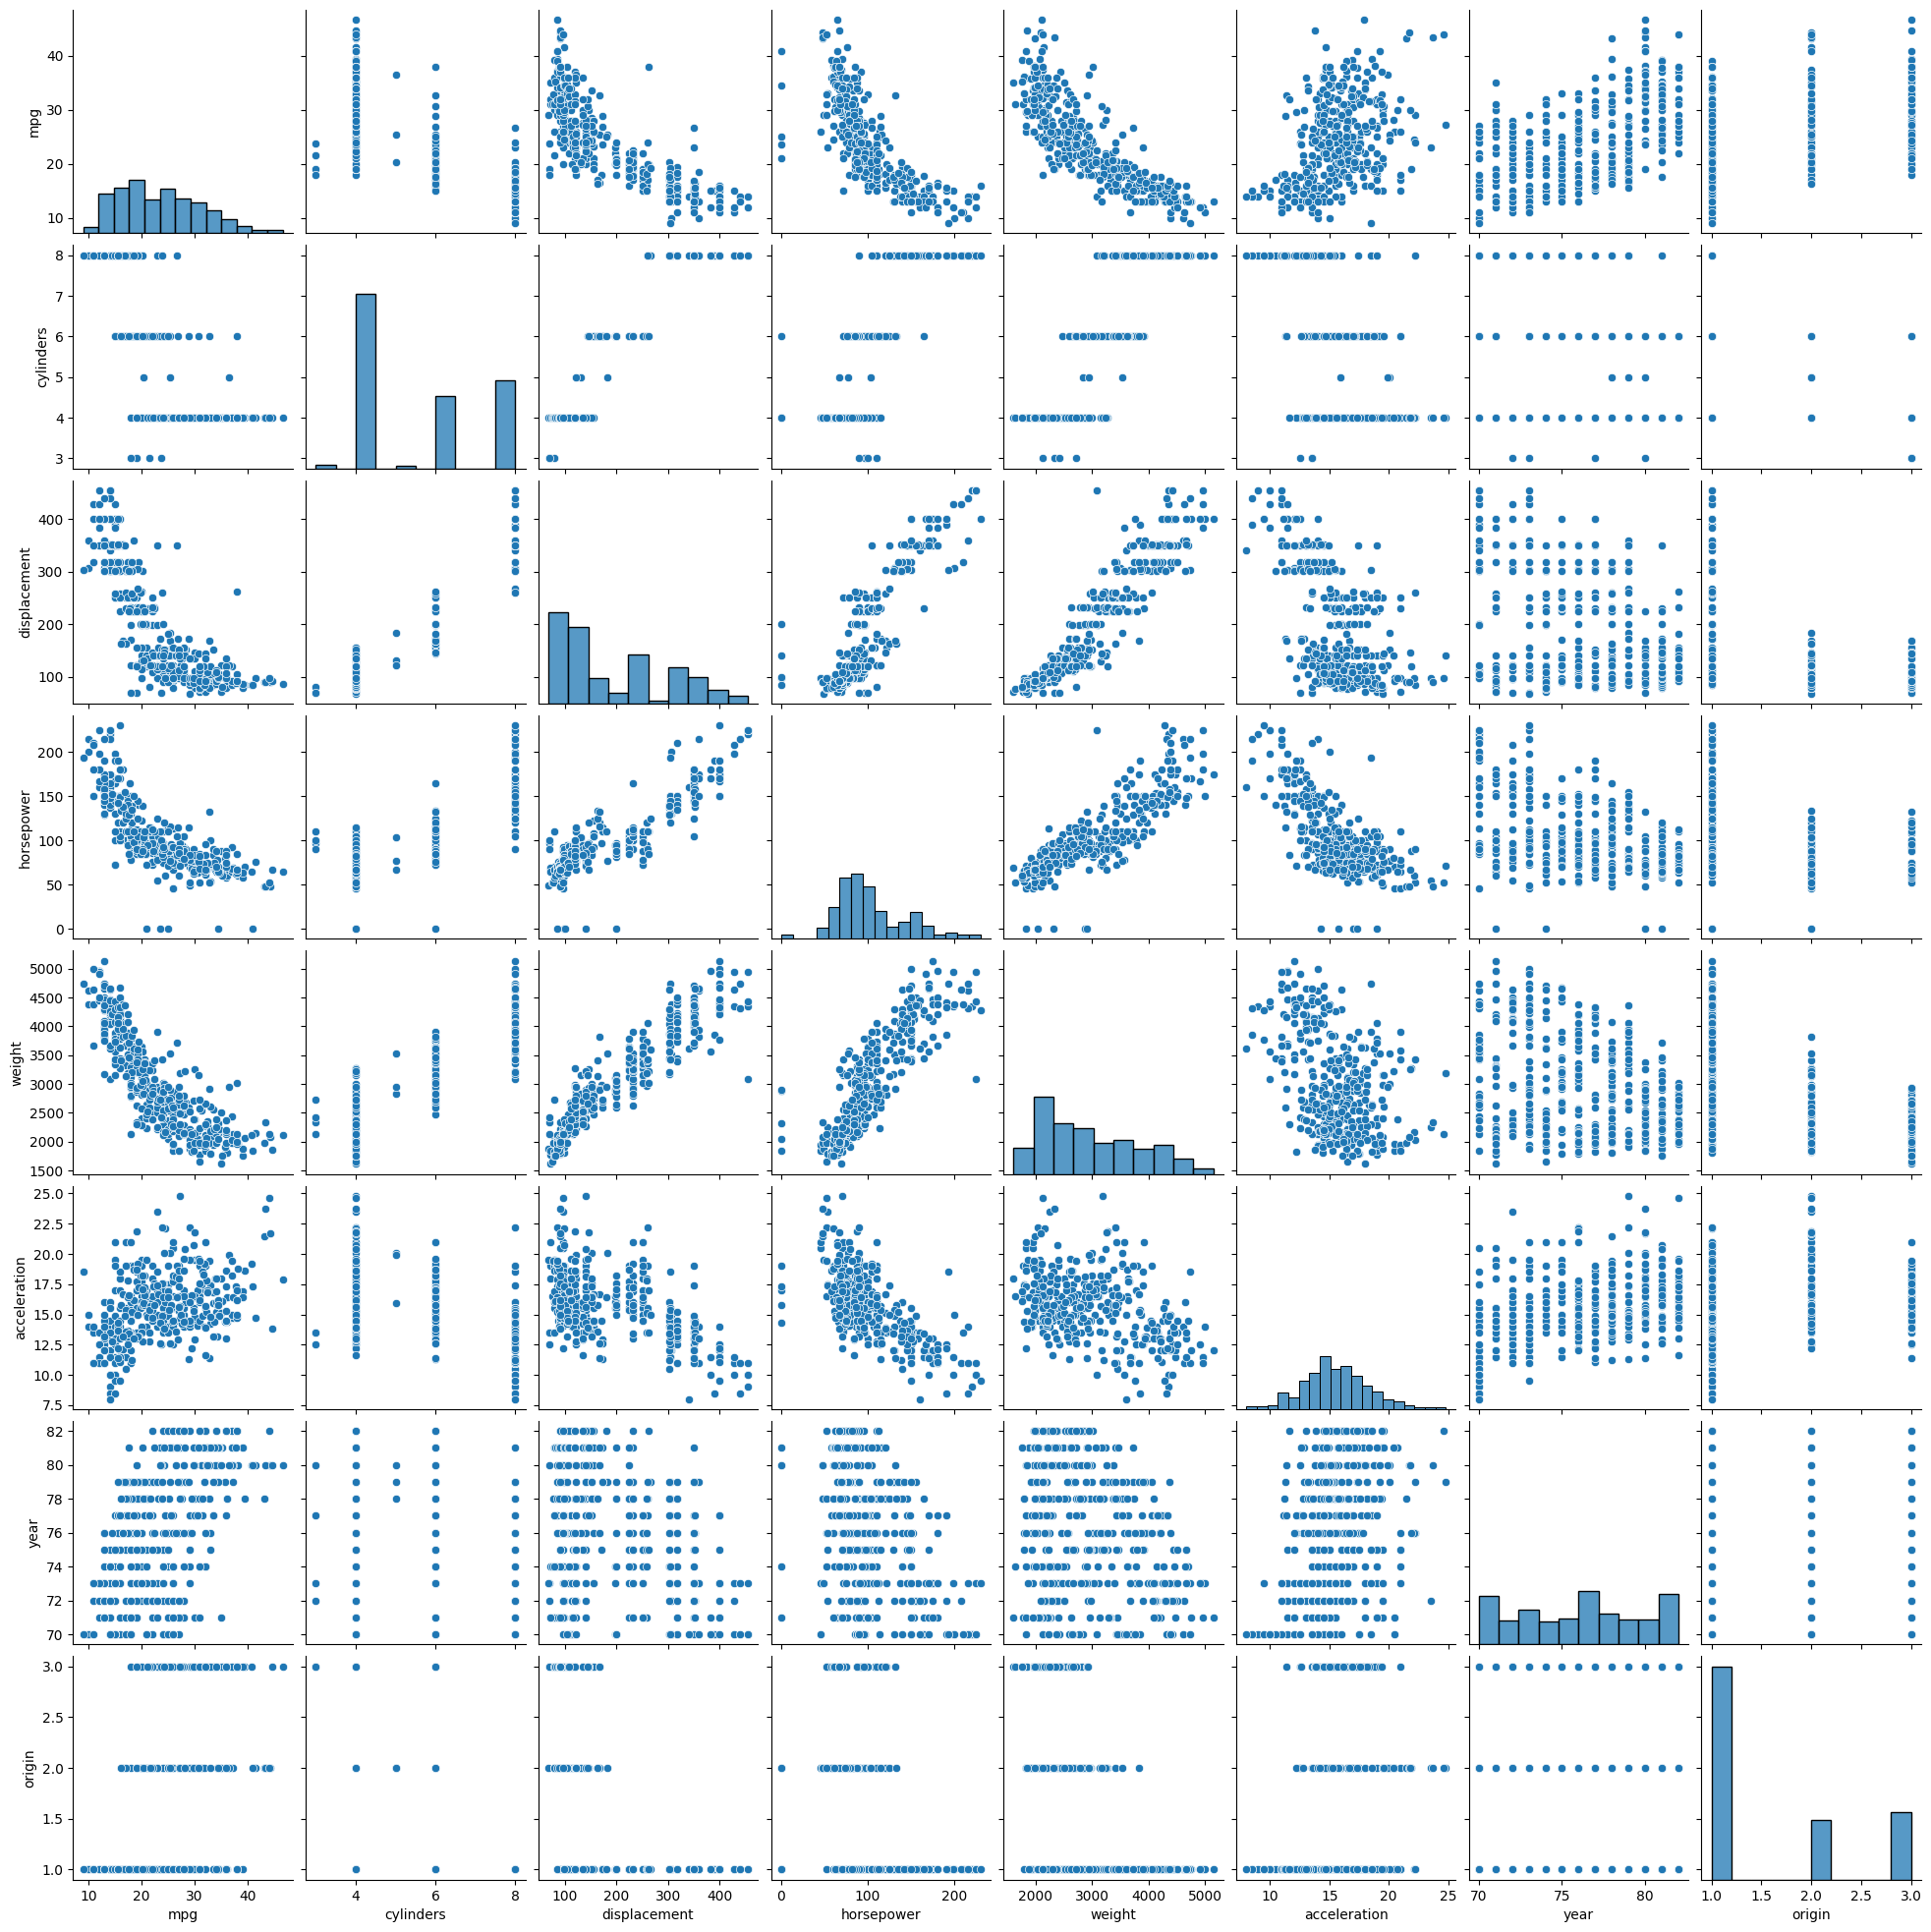

In [8]:
# Scatterplot matrix using Seaborn
sns.pairplot(df);

In [10]:
# mpg seems to have a non-linear relationship with: displacement, horsepower and weight. 
# Dataset
X = df['horsepower'].to_numpy()[:, np.newaxis]
y = df['mpg'].to_numpy()


In [11]:
for i in range (1,11):
    model = Pipeline([('poly', PolynomialFeatures(degree=i)), 
                      ('linear', LinearRegression())])
    model.fit(X,y)

    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

    print("Degree: %i  CV mean squared error: %.3f" % (i, np.mean(np.abs(score))))

Degree: 1  CV mean squared error: 32.573
Degree: 2  CV mean squared error: 30.515
Degree: 3  CV mean squared error: 27.440
Degree: 4  CV mean squared error: 25.396
Degree: 5  CV mean squared error: 24.986
Degree: 6  CV mean squared error: 24.868
Degree: 7  CV mean squared error: 25.635
Degree: 8  CV mean squared error: 25.537
Degree: 9  CV mean squared error: 25.237
Degree: 10  CV mean squared error: 25.761


In [12]:
for i in range(3,11):  # The degrees of freedom can't be less than 3 in a cubic spline
    transformed = dmatrix("bs(df.horsepower, df=%i, degree=3)" % i,
                         {"df.horsepower":df.horsepower},
                          return_type='dataframe')  # Cubic spline basis representation
    lin = LinearRegression()
    lin.fit(transformed, y)

    score = cross_val_score(lin, transformed, y, cv=10, scoring='neg_mean_squared_error')

    print('Number of degrees of freedom: %i  CV mean squared error: %.3f' %(i, np.mean(np.abs(score))))

Number of degrees of freedom: 3  CV mean squared error: 24.268
Number of degrees of freedom: 4  CV mean squared error: 22.195
Number of degrees of freedom: 5  CV mean squared error: 22.319
Number of degrees of freedom: 6  CV mean squared error: 22.028
Number of degrees of freedom: 7  CV mean squared error: 22.099
Number of degrees of freedom: 8  CV mean squared error: 22.145
Number of degrees of freedom: 9  CV mean squared error: 21.783
Number of degrees of freedom: 10  CV mean squared error: 21.965


In [13]:
for i in range(3,11):  # The degrees of freedom can't be less than 3 in a cubic spline
    transformed = dmatrix("cr(df.horsepower, df=%i)" % i,
                         {"df.horsepower":df.horsepower},
                          return_type='dataframe')  # Cubic spline basis representation
    lin = LinearRegression()
    lin.fit(transformed, y)

    score = cross_val_score(lin, transformed, y, cv=10, scoring='neg_mean_squared_error')

    print('Number of degrees of freedom: %i  CV mean squared error: %.3f' %(i, np.mean(np.abs(score))))

Number of degrees of freedom: 3  CV mean squared error: 27.537
Number of degrees of freedom: 4  CV mean squared error: 24.402
Number of degrees of freedom: 5  CV mean squared error: 22.249
Number of degrees of freedom: 6  CV mean squared error: 21.776
Number of degrees of freedom: 7  CV mean squared error: 21.877
Number of degrees of freedom: 8  CV mean squared error: 21.939
Number of degrees of freedom: 9  CV mean squared error: 21.981
Number of degrees of freedom: 10  CV mean squared error: 22.248


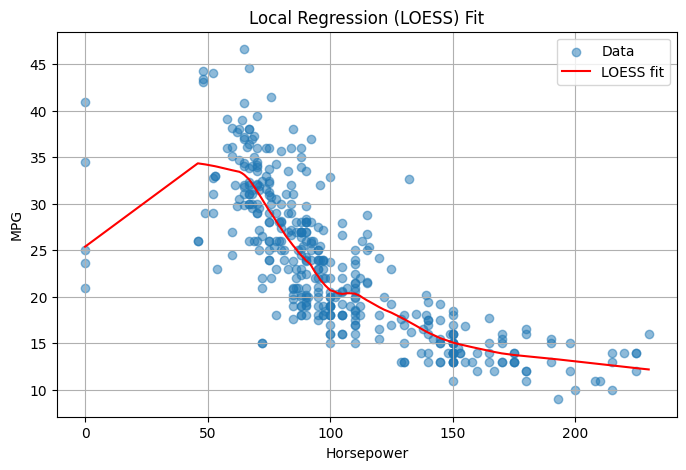

In [14]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Fit local regression (LOESS)
loess_result = lowess(y, X.flatten(), frac=0.3, return_sorted=True)

# Plot the result
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(loess_result[:, 0], loess_result[:, 1], color='red', label='LOESS fit')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Local Regression (LOESS) Fit')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Try different fractions as a proxy for degree of freedom
fractions = [0.1, 0.2, 0.3, 0.4, 0.5]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Fraction (Degree of Smoothing) | CV Mean Squared Error")
for frac in fractions:
    mse_list = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx].flatten(), X[test_idx].flatten()
        y_train, y_test = y[train_idx], y[test_idx]
        loess_fit = lowess(y_train, X_train, frac=frac, return_sorted=True)
        # Interpolate LOESS fit for test set
        y_pred = np.interp(X_test, loess_fit[:, 0], loess_fit[:, 1])
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)
    print(f"{frac:<28} {np.mean(mse_list):.3f}")

Fraction (Degree of Smoothing) | CV Mean Squared Error
0.1                          21.112
0.2                          20.075
0.3                          19.725
0.4                          19.956
0.5                          20.934


GAM CV Mean Squared Error: 19.450


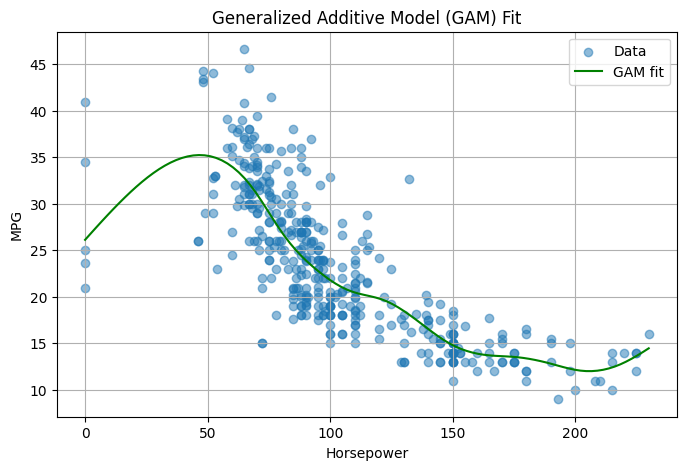

In [16]:
from pygam import LinearGAM, s
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Fit GAM model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
gam_mse_list = []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    gam = LinearGAM(s(0)).fit(X_train, y_train)
    y_pred = gam.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    gam_mse_list.append(mse)
print(f"GAM CV Mean Squared Error: {np.mean(gam_mse_list):.3f}")

# Plot GAM fit
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.5, label='Data')
XX = np.linspace(X.min(), X.max(), 100)
plt.plot(XX, gam.predict(XX), color='green', label='GAM fit')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Generalized Additive Model (GAM) Fit')
plt.legend()
plt.grid(True)
plt.show()

Best LOESS fraction: 0.25 with CV MSE: 19.653
Best GAM spline count: 10 with CV MSE: 19.524
Best GAM spline count: 10 with CV MSE: 19.524


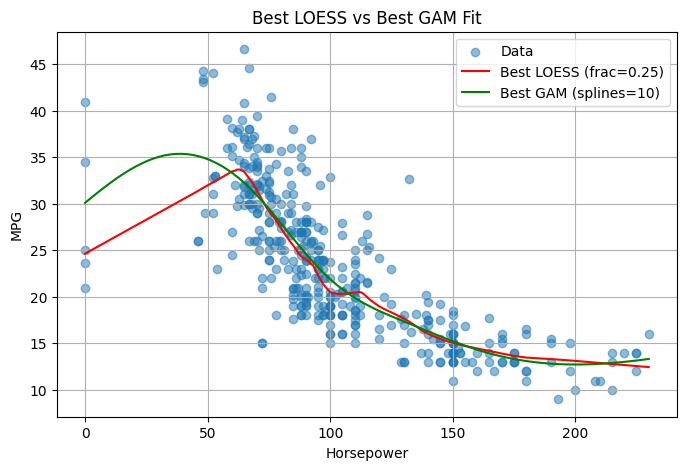

In [21]:
# Automated selection of best LOESS fraction
best_loess_mse = float('inf')
best_loess_frac = None
fractions = np.linspace(0.1, 0.5, 9)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for frac in fractions:
    mse_list = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx].flatten(), X[test_idx].flatten()
        y_train, y_test = y[train_idx], y[test_idx]
        loess_fit = lowess(y_train, X_train, frac=frac, return_sorted=True)
        y_pred = np.interp(X_test, loess_fit[:, 0], loess_fit[:, 1])
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)
    mean_mse = np.mean(mse_list)
    if mean_mse < best_loess_mse:
        best_loess_mse = mean_mse
        best_loess_frac = frac
print(f"Best LOESS fraction: {best_loess_frac:.2f} with CV MSE: {best_loess_mse:.3f}")

# Automated selection of best GAM spline count
best_gam_mse = float('inf')
best_gam_splines = None
for splines in range(4, 11):
    gam_mse_list = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        gam = LinearGAM(s(0, n_splines=splines)).fit(X_train, y_train.ravel())
        y_pred = gam.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        gam_mse_list.append(mse)
    mean_mse = np.mean(gam_mse_list)
    if mean_mse < best_gam_mse:
        best_gam_mse = mean_mse
        best_gam_splines = splines
print(f"Best GAM spline count: {best_gam_splines} with CV MSE: {best_gam_mse:.3f}")

# Compare best models visually
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.5, label='Data')
# Best LOESS fit
loess_result = lowess(y, X.flatten(), frac=best_loess_frac, return_sorted=True)
plt.plot(loess_result[:, 0], loess_result[:, 1], color='red', label=f'Best LOESS (frac={best_loess_frac:.2f})')
# Best GAM fit
XX = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
gam_best = LinearGAM(s(0, n_splines=best_gam_splines)).fit(X, y.ravel())
plt.plot(XX, gam_best.predict(XX), color='green', label=f'Best GAM (splines={best_gam_splines})')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Best LOESS vs Best GAM Fit')
plt.legend()
plt.grid(True)
plt.show()


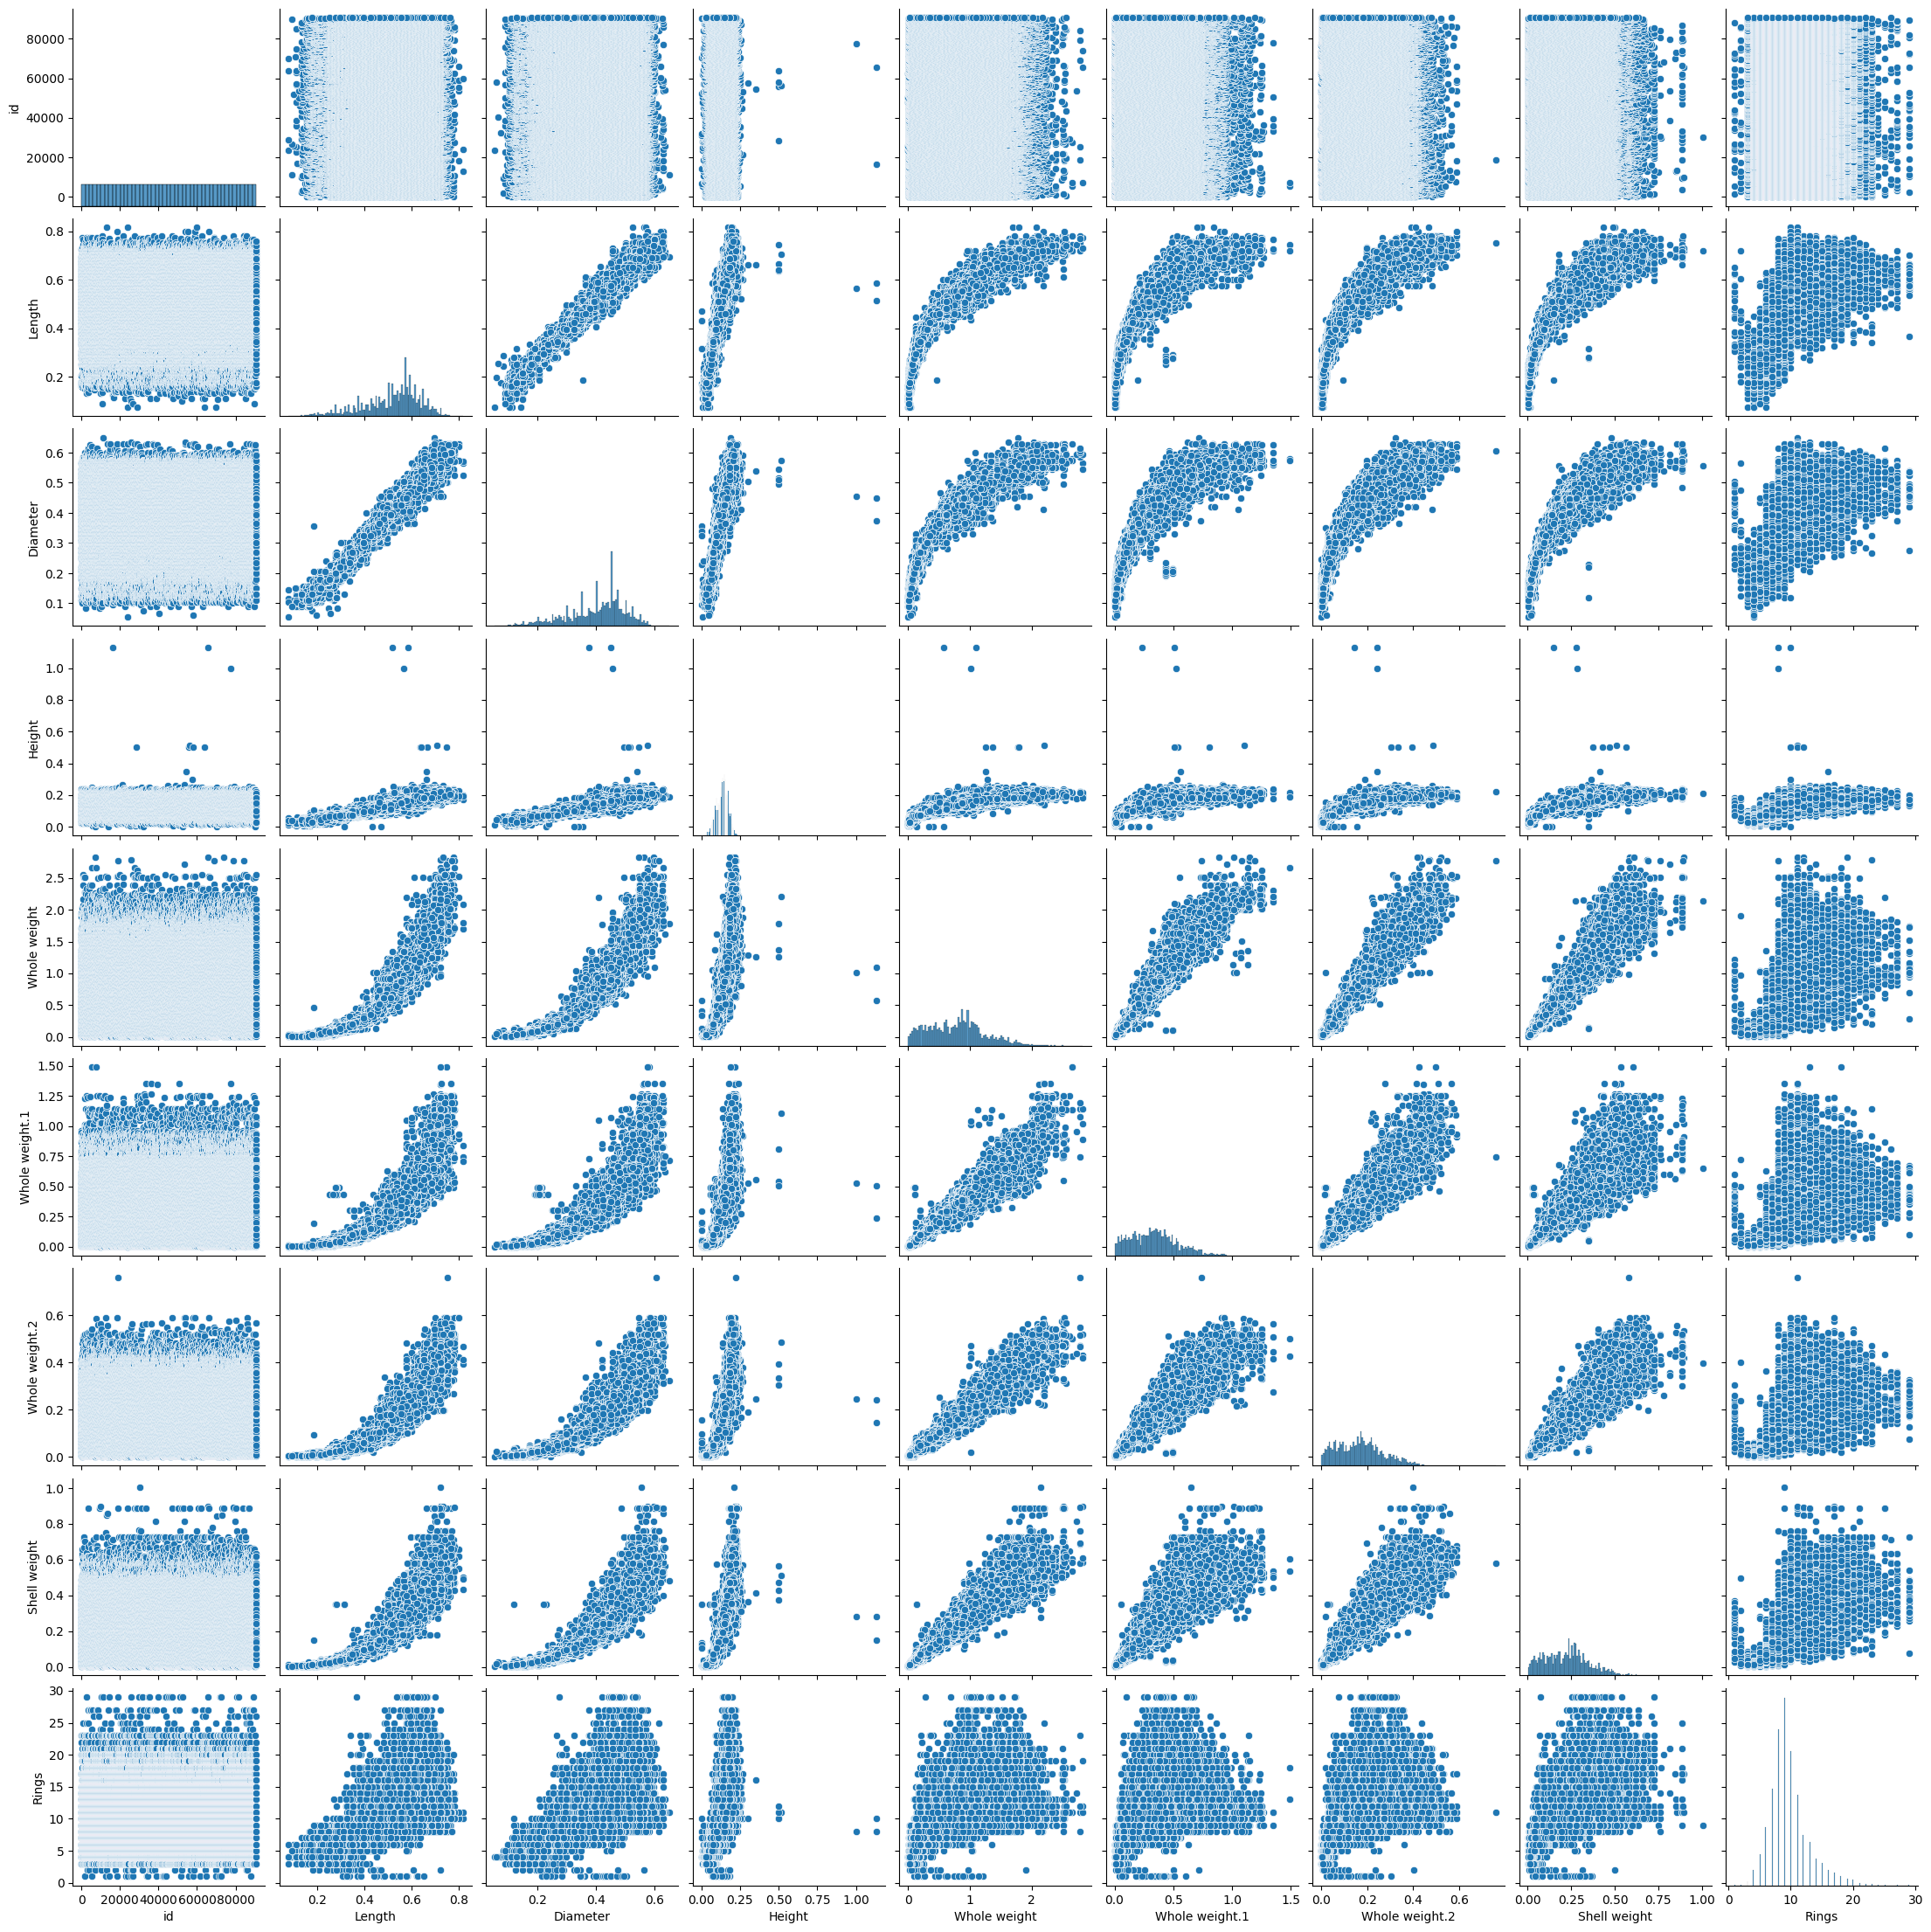

In [45]:
train_df = pd.read_csv('../train.csv')
# Scatterplot matrix using Seaborn
sns.pairplot(train_df);
test_df = pd.read_csv('../test.csv')

In [32]:
test_df.head()  # Display the first few rows of the test DataFrame

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [46]:
test_df.drop(columns=['Sex'], inplace=True)



Best LOESS fraction: 0.10 with CV MSE: 6.715
Best GAM spline count: 10 with CV MSE: 6.108
Best GAM spline count: 10 with CV MSE: 6.108


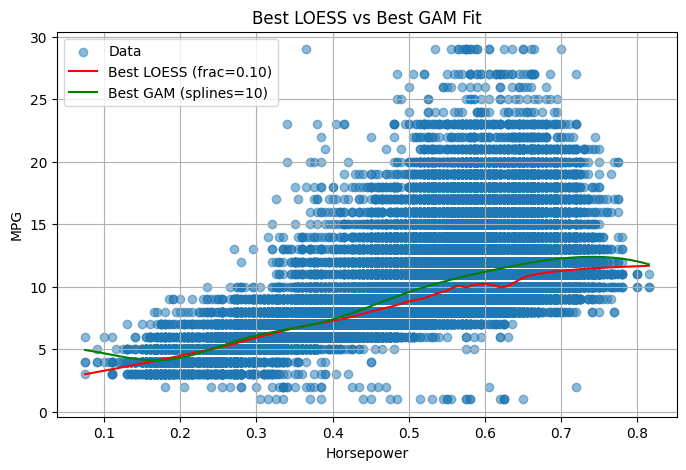

In [50]:
# mpg seems to have a non-linear relationship with: displacement, horsepower and weight. 
# Dataset
X = train_df['Length'].to_numpy()[:, np.newaxis]
y = train_df['Rings'].to_numpy()
# Automated selection of best LOESS fraction
best_loess_mse = float('inf')
best_loess_frac = None
fractions = np.linspace(0.1, 0.5, 9)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for frac in fractions:
    mse_list = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx].flatten(), X[test_idx].flatten()
        y_train, y_test = y[train_idx], y[test_idx]
        loess_fit = lowess(y_train, X_train, frac=frac, return_sorted=True)
        y_pred = np.interp(X_test, loess_fit[:, 0], loess_fit[:, 1])
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)
    mean_mse = np.mean(mse_list)
    if mean_mse < best_loess_mse:
        best_loess_mse = mean_mse
        best_loess_frac = frac
print(f"Best LOESS fraction: {best_loess_frac:.2f} with CV MSE: {best_loess_mse:.3f}")

# Automated selection of best GAM spline count
best_gam_mse = float('inf')
best_gam_splines = None
for splines in range(4, 11):
    gam_mse_list = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        gam = LinearGAM(s(0, n_splines=splines)).fit(X_train, y_train.ravel())
        y_pred = gam.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        gam_mse_list.append(mse)
    mean_mse = np.mean(gam_mse_list)
    if mean_mse < best_gam_mse:
        best_gam_mse = mean_mse
        best_gam_splines = splines
print(f"Best GAM spline count: {best_gam_splines} with CV MSE: {best_gam_mse:.3f}")

# Compare best models visually
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.5, label='Data')
# Best LOESS fit
loess_result = lowess(y, X.flatten(), frac=best_loess_frac, return_sorted=True)
plt.plot(loess_result[:, 0], loess_result[:, 1], color='red', label=f'Best LOESS (frac={best_loess_frac:.2f})')
# Best GAM fit
XX = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
gam_best = LinearGAM(s(0, n_splines=best_gam_splines)).fit(X, y.ravel())
plt.plot(XX, gam_best.predict(XX), color='green', label=f'Best GAM (splines={best_gam_splines})')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Best LOESS vs Best GAM Fit')
plt.legend()
plt.grid(True)
plt.show()


      id  Predicted_Rings
0  90615        11.759236
1  90616        10.921490
2  90617        10.629715
3  90618        10.778333
4  90619         7.673781


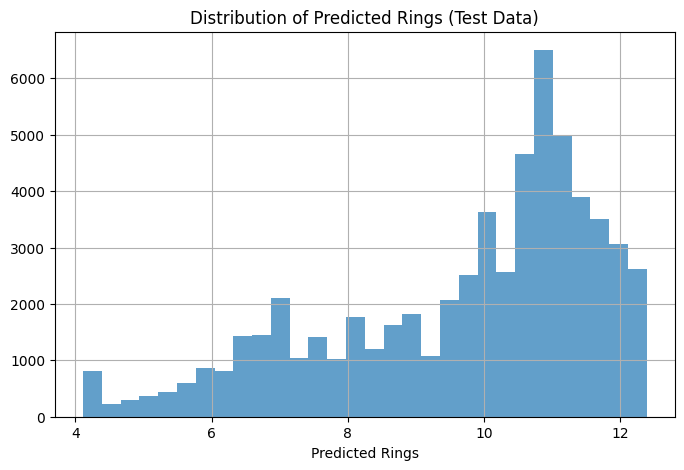

In [52]:
# Use all numeric columns except 'Rings' for prediction
import numpy as np
from pygam import LinearGAM, s

# Get feature columns (exclude 'Rings')
feature_cols = [col for col in train_df.columns if col != 'Rings' and np.issubdtype(train_df[col].dtype, np.number)]
X_train = train_df['Length'].to_numpy()
y_train = train_df['Rings'].to_numpy().ravel()
X_test = test_df['Length'].to_numpy()

# Fit a GAM with one spline per feature
# gam = LinearGAM(sum([s(i) for i in range(len(feature_cols))])).fit(X_train, y_train)
gam = LinearGAM(s(0, n_splines=10)).fit(X_train, y_train)
# y_pred = gam.predict(X_test)
test_df['Predicted_Rings'] = gam.predict(X_test)

# Show first few predictions
print(test_df[['id','Predicted_Rings']].head())

# Plot predicted rings distribution
plt.figure(figsize=(8, 5))
plt.hist(test_df['Predicted_Rings'], bins=30, alpha=0.7)
plt.xlabel('Predicted Rings')
plt.title('Distribution of Predicted Rings (Test Data)')
plt.grid(True)
plt.show()


      id  Predicted_Rings_LOESS  Predicted_Rings
0  90615              10.560040        11.800348
1  90616              10.034832        10.943975
2  90617               9.980932        10.606124
3  90618              10.033034        10.778453
4  90619               7.447420         7.825018


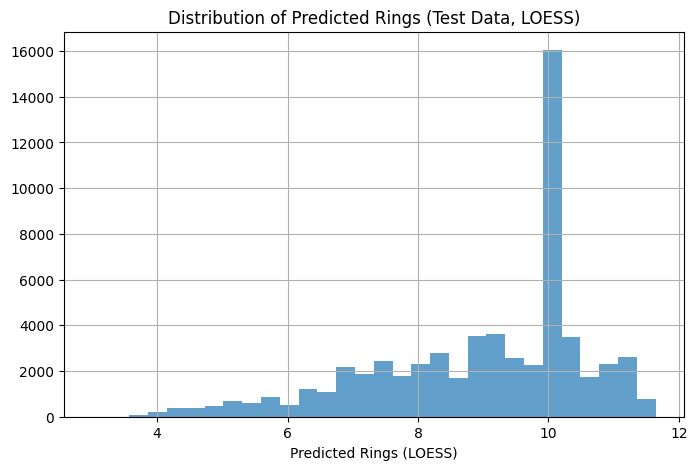

In [51]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

# Use Length as the feature for local regression
X_train = train_df['Length'].to_numpy()
y_train = train_df['Rings'].to_numpy()
X_test = test_df['Length'].to_numpy()

# Fit LOESS on train data
loess_fit = lowess(y_train, X_train, frac=0.1, return_sorted=True)

# Predict Rings for test data by interpolation
predicted_rings = np.interp(X_test, loess_fit[:, 0], loess_fit[:, 1])
test_df['Predicted_Rings_LOESS'] = predicted_rings

# Show first few predictions
print(test_df[['id', 'Predicted_Rings_LOESS','Predicted_Rings']].head())

# Plot predicted rings distribution
plt.figure(figsize=(8, 5))
plt.hist(test_df['Predicted_Rings_LOESS'], bins=30, alpha=0.7)
plt.xlabel('Predicted Rings (LOESS)')
plt.title('Distribution of Predicted Rings (Test Data, LOESS)')
plt.grid(True)
plt.show()


In [53]:
# save predictions to CSV
test_df[['id', 'Predicted_Rings']].to_csv('predictions_GAM.csv', index=False)
test_df[['id', 'Predicted_Rings_LOESS']].to_csv('predictions_LOESS.csv', index=False)
